<a href="https://colab.research.google.com/github/Topolewski-Kamil/dKnn/blob/main/keras_dis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modules

In [9]:
%tensorflow_version 2.x
# !pip install pynndescent

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model
import string

import pynndescent
import numpy as np
import h5py
from urllib.request import urlretrieve
import os
import seaborn as sns

!mkdir adv_datasets

mkdir: cannot create directory ‘adv_datasets’: File exists


Import Mnist dataset

In [10]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Initialize CNN model

In [11]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding="same", activation="relu", input_shape=x_train.shape[1:]),
        layers.Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding="valid", activation="relu"),
        layers.Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding="valid", activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation=None),
        layers.Dense(10, activation=tf.nn.softmax),
    ]
)

batch_size = 500
epochs = 8

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Train model


In [12]:
try:
  keras.backend.set_learning_phase(False)
  model = load_model('deepKNN_model.h5')
  print("loaded model successfully")
except: 
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1) #0.1
  model.save('deepKNN_model.h5')  # creates a HDF5 file
  print("saved model successfully")

loaded model successfully


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Evaluate model

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03186888247728348
Test accuracy: 0.9901000261306763


Plot image

In [14]:
def plot_image(img):
  plt.imshow(img.reshape((28, 28)), cmap='gray', interpolation='none')
  cbar = plt.colorbar()
  cbar.set_label('Pixel Intensity')
  plt.show()

Generate Adversarial Examples

In [15]:
# import the necessary packages
from tensorflow.keras.losses import MSE
import tensorflow as tf
def generate_image_adversary(model, image, label, eps):
  # cast the image
  image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)
  # record our gradients
  with tf.GradientTape() as tape:
    # explicitly indicate that our image should be tacked for
    # gradient updates
    tape.watch(image)
    # use our model to make predictions on the input image and
    # then compute the loss
    pred = model(image)
    loss = MSE(label, pred)

    # calculate the gradients of loss with respect to the image, then
    # compute the sign of the gradient
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)
    # construct the image adversary
    adversary = (image + (signedGrad * eps)).numpy()
    # return the image adversary to the calling function
    return adversary.reshape(28, 28, 1)

In [16]:
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]
adversaries = {}

def load_adversaries(adversaries):  
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    path = 'adv_datasets/adversaries' + eps_str + '.npy'
    adversaries[eps] = np.load(path)

def save_adversaries():
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    filename = 'adv_datasets/adversaries' + eps_str + '.npy'
    np.save(filename, adversaries[eps])

try:
  epsilons.insert(0, 0.0)
  load_adversaries(adversaries)
  print('loaded adversaries dataset successfully')
except:
  for eps in epsilons:
    adv = []
    for i in range(x_test.shape[0]):
      adv.append(generate_image_adversary(model, x_test[i], y_test[i], eps))
    adversaries[eps] = np.array(adv)
  epsilons.insert(0, 0.0)
  adversaries[0.0] = x_test
  save_adversaries()
  print('saved adversaries dataset successfully')

loaded adversaries dataset successfully


Test model on adversarial attacks

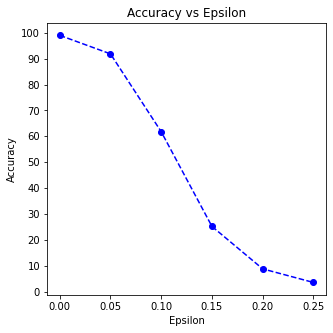

In [17]:
accuracies_plot = []
for eps in epsilons:
  adversary_score = model.evaluate(adversaries[eps], y_test, verbose=0)
  accuracies_plot.append(adversary_score[1] * 100)
  
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_plot, linestyle='--', marker='o', color='b')
plt.yticks(np.arange(0, 101, step=10))
plt.xticks(np.arange(0, .26, step=0.05))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epsilon")
plt.show()

Plot some adversarial examples

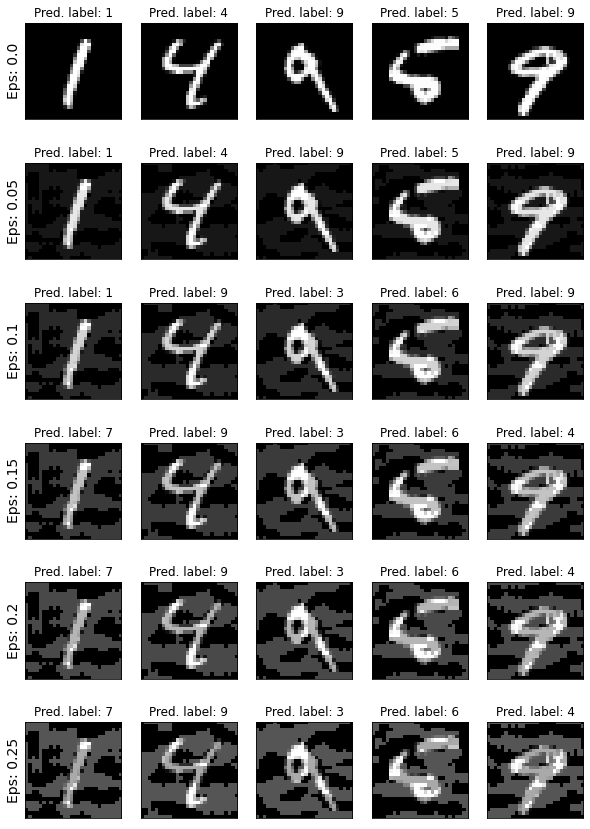

In [18]:
cnt = 0
plt.figure(figsize=(10,15))
for eps in epsilons:
  adv_img = adversaries[eps][5:10]
  true_label = y_test[5:10]

  adv_results = model.predict(adversaries[eps][5:10])
  predicted_labels = []
  for result in adv_results:
    predicted_labels.append(np.argmax(result))

  for i in range(5):
      cnt += 1
      plt.subplot(len(epsilons), 5, cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if i == 0:
        plt.ylabel("Eps: {}".format(eps), fontsize=14)
      plt.title("Pred. label: {}".format(predicted_labels[i]))
      plt.imshow(np.squeeze(adv_img[i]), cmap="gray")
# plt.tight_layout()
plt.show()

KNN for patterns

In [19]:
# reformat training data
x_train_knn = np.squeeze(x_train, -1)
x_train_knn = x_train_knn.reshape((60000, 784))

# index training data
index = pynndescent.NNDescent(x_train_knn)

# prepare for faster query
index.prepare()

# reformat test data
x_test_knn = np.squeeze(x_test, -1)
x_test_knn = x_test_knn.reshape((10000, 784))

# find neighbors for test data
neighbors = index.query(x_test_knn)

In [20]:
### create gold standard from KDTree ###
# from sklearn.neighbors import KDTree
# tree_index = KDTree(x_train)

# %%time
# tree_neighbors = tree_index.query(x_test, k=10)

In [21]:
def accuracy_per_query_point(approx_neighbors, true_neighbors):
    approx_indices = approx_neighbors[0]
    result = np.zeros(approx_indices.shape[0])
    for i in range(approx_indices.shape[0]):
        n_correct = np.intersect1d(approx_indices[i], true_neighbors[i]).shape[0]
        result[i] = n_correct / true_neighbors.shape[1]
    return result

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Average accuracy of 0.9678400000000001


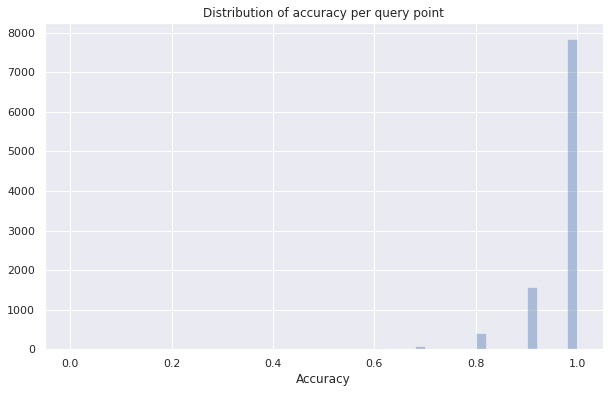

In [22]:
tree_N = np.load('test_true_neighbors.npy')

accuracy_stats = accuracy_per_query_point(neighbors, tree_N)
sns.set(rc={"figure.figsize":(10,6)})

sns.distplot(accuracy_stats, kde=False)
plt.title("Distribution of accuracy per query point")
plt.xlabel("Accuracy")
print(f"Average accuracy of {np.mean(accuracy_stats)}")

KNN for first CNN layer

Get activations on each layer

In [23]:
def reshaped_layer(model, x):
    #function to get the layer wise output representation of the model for data x
    layer_output = []

    for i in [0,1,2,5]:
        layer = model.layers[i]
        l_op = K.function([model.layers[0].input], [layer.output])([x])[0]
        layer_output.append(l_op)

    reshaped_output_layer = []
    
    for output in layer_output[0:3]:
        reshaped_output_layer.append(output.reshape(output.shape[0], output.shape[1]*output.shape[2]*output.shape[3]))
        
    reshaped_output_layer.append(layer_output[3])
    
    for layer in reshaped_output_layer:
        assert layer.dtype == np.float32
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)
    return(reshaped_output_layer)

activations = reshaped_layer(model, x_test)

In [24]:
# first_act = activations[0]
# print(activations[0].shape)
# # index training data
# index_act_1 = pynndescent.NNDescent(first_act)

# # prepare for faster query
# index_act_1.prepare()

In [25]:
# # reformat test data
# x_test_knn = np.squeeze(x_test, -1)
# x_test_knn = x_test_knn.reshape((10000, 784))

In [26]:
# # find neighbors for test data
# neighbors = index.query(x_test_knn)